In [1]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.sndcgan as sndcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREATS = torch.get_num_threads()
    print("Number of Threats: ", NUM_THREATS)
else:
    NUM_THREATS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threats:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 128
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 21
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs","sndcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 10
SAVE_FAKES_EVERY_N_EPOCHS = 5

### Load dataset

In [5]:
# Poster subset:
GENRE=['Horror']
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=None
SORT=None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREATS, pin_memory=True)

Sample dataset:

The dataset has 18119 entries.


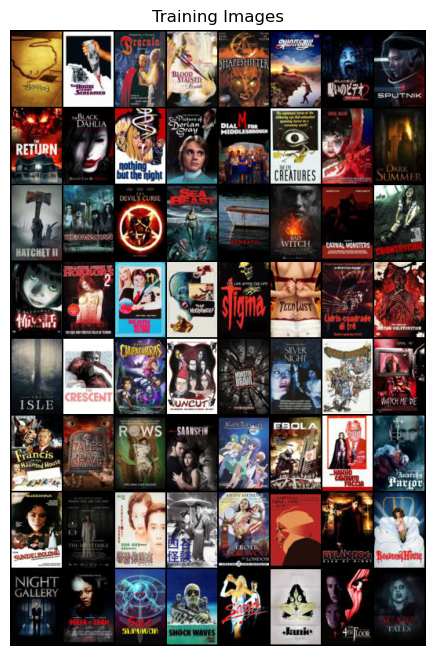

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = sndcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [8]:
trainer = sndcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

[0/20]	Loss_D: 0.7210	Loss_G: 0.7080	D(x): 0.9684	D(G(z)): 0.4962 / 0.4926: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s] 


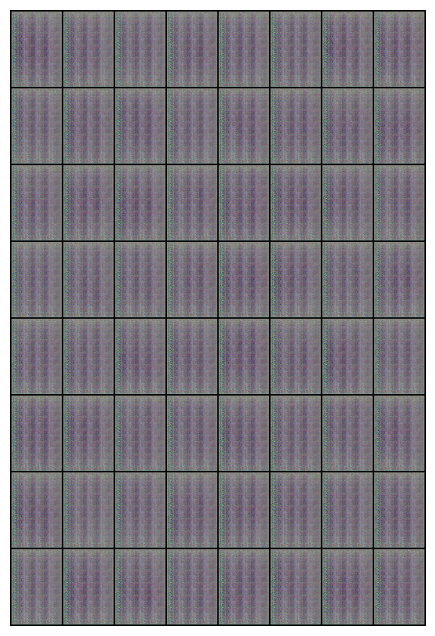

[1/20]	Loss_D: 1.2527	Loss_G: 0.6291	D(x): 0.5878	D(G(z)): 0.5104 / 0.5355: 100%|██████████| 284/284 [01:59<00:00,  2.38it/s]
[2/20]	Loss_D: 1.2937	Loss_G: 0.6978	D(x): 0.5607	D(G(z)): 0.4975 / 0.4979: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s]
[3/20]	Loss_D: 1.4271	Loss_G: 0.7248	D(x): 0.5512	D(G(z)): 0.5550 / 0.4858: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s]
[4/20]	Loss_D: 1.2122	Loss_G: 0.6181	D(x): 0.6414	D(G(z)): 0.5262 / 0.5420: 100%|██████████| 284/284 [01:57<00:00,  2.43it/s]
[5/20]	Loss_D: 1.3129	Loss_G: 0.6727	D(x): 0.5202	D(G(z)): 0.4813 / 0.5110: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]


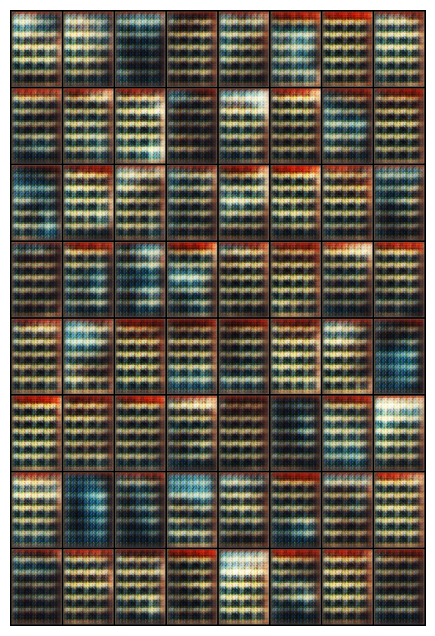

[6/20]	Loss_D: 1.3572	Loss_G: 0.6463	D(x): 0.5328	D(G(z)): 0.5166 / 0.5242: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]
[7/20]	Loss_D: 1.3960	Loss_G: 0.7909	D(x): 0.4529	D(G(z)): 0.4534 / 0.4534: 100%|██████████| 284/284 [01:56<00:00,  2.43it/s]
[8/20]	Loss_D: 1.3822	Loss_G: 0.6697	D(x): 0.5103	D(G(z)): 0.5068 / 0.5123: 100%|██████████| 284/284 [01:56<00:00,  2.43it/s]
[9/20]	Loss_D: 1.3890	Loss_G: 0.7433	D(x): 0.4754	D(G(z)): 0.4753 / 0.4756: 100%|██████████| 284/284 [01:57<00:00,  2.43it/s]
[10/20]	Loss_D: 1.3917	Loss_G: 0.7523	D(x): 0.4703	D(G(z)): 0.4712 / 0.4713: 100%|██████████| 284/284 [01:57<00:00,  2.43it/s]


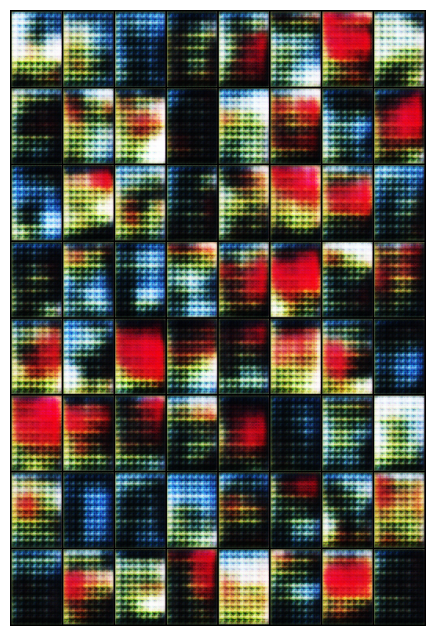

[11/20]	Loss_D: 1.3704	Loss_G: 0.7051	D(x): 0.5106	D(G(z)): 0.5022 / 0.4942: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]
[12/20]	Loss_D: 1.3730	Loss_G: 0.6834	D(x): 0.5088	D(G(z)): 0.5019 / 0.5049: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s]
[13/20]	Loss_D: 1.3886	Loss_G: 0.7463	D(x): 0.4743	D(G(z)): 0.4742 / 0.4741: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]
[14/20]	Loss_D: 1.3604	Loss_G: 0.5563	D(x): 0.4740	D(G(z)): 0.4584 / 0.5736: 100%|██████████| 284/284 [01:57<00:00,  2.43it/s]
[15/20]	Loss_D: 1.3805	Loss_G: 0.7352	D(x): 0.4855	D(G(z)): 0.4820 / 0.4794: 100%|██████████| 284/284 [01:56<00:00,  2.43it/s]


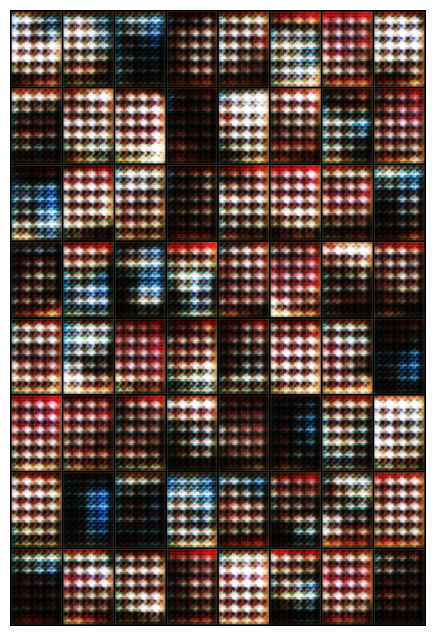

[16/20]	Loss_D: 1.3802	Loss_G: 0.7010	D(x): 0.5028	D(G(z)): 0.4997 / 0.4961: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s]
[17/20]	Loss_D: 1.3734	Loss_G: 0.7019	D(x): 0.5095	D(G(z)): 0.5014 / 0.4960: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]
[18/20]	Loss_D: 1.3813	Loss_G: 0.6853	D(x): 0.5071	D(G(z)): 0.5043 / 0.5040: 100%|██████████| 284/284 [01:57<00:00,  2.41it/s]
[19/20]	Loss_D: 1.3657	Loss_G: 0.6298	D(x): 0.5091	D(G(z)): 0.4972 / 0.5331: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]
[20/20]	Loss_D: 1.3882	Loss_G: 0.6904	D(x): 0.5004	D(G(z)): 0.5013 / 0.5014: 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]


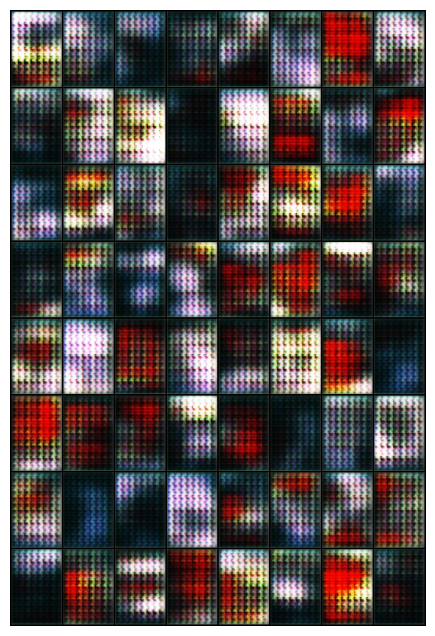

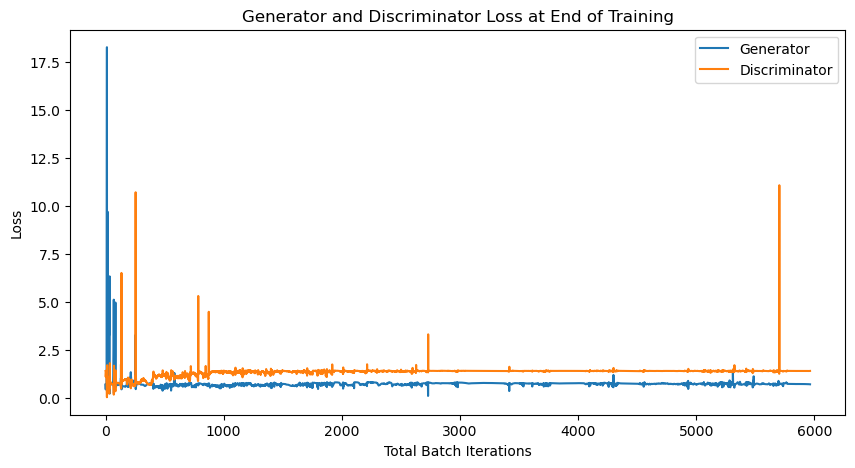

In [9]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS, show_graphs=SHOW_GRAPHS)

### Show results

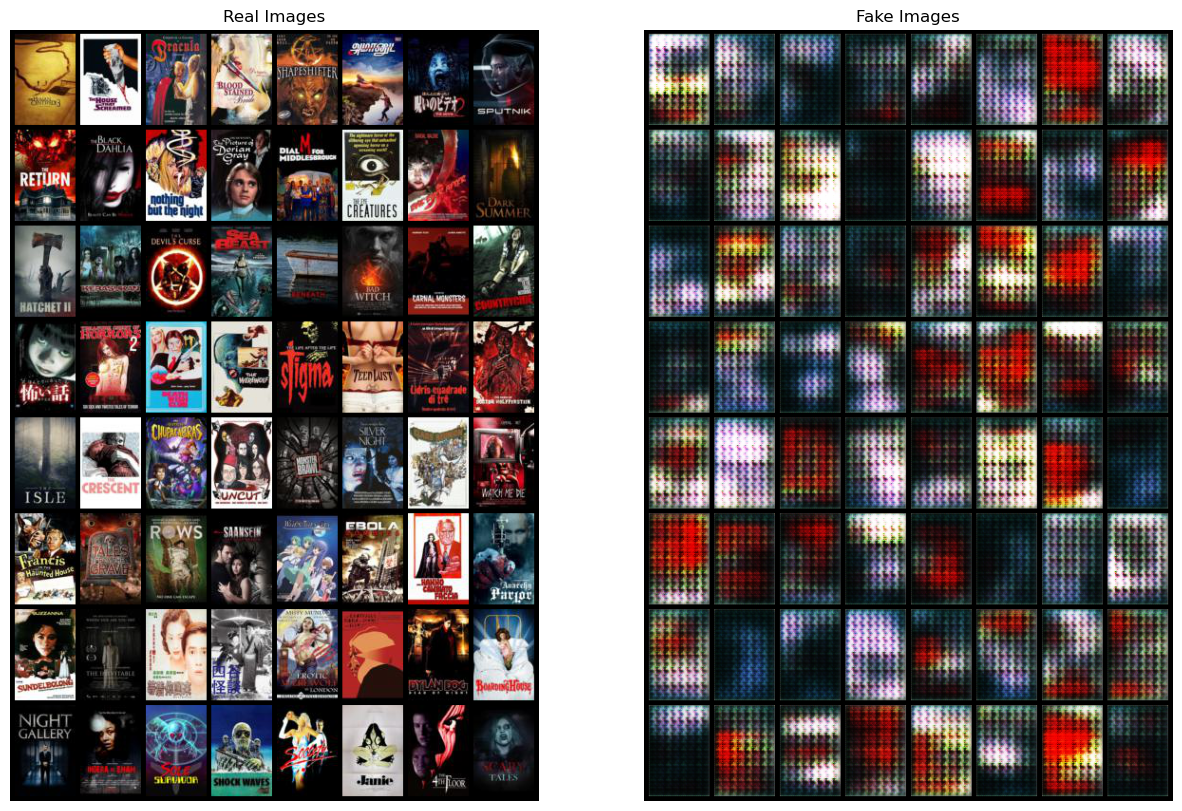

In [10]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))